In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 531472, done.
remote: Counting objects: 100% (45082/45082), done.
remote: Compressing objects: 100% (2074/2074), done.
remote: Total 531472 (delta 43039), reused 44915 (delta 42935), pack-reused 486390
Receiving objects: 100% (531472/531472), 1.00 GiB | 14.23 MiB/s, done.
Resolving deltas: 100% (496283/496283), done.
fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [3]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


In [4]:
# defining the files directory and testing directory
train_dir = '/kaggle/input/pedestriansyntheticdataset/train/train'
test_dir = '/kaggle/input/citypersons-testselection/NewTest/'

In [5]:
class ImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
       # self.imgs = [image for image in sorted(os.listdir(files_dir))
                       # if image[-4:]=='.jpg']
        
        self.imgs = [image for image in sorted(os.listdir(files_dir)) if image.endswith(('.png', '.jpg'))]
        
        
        
        # classes: 0 index is reserved for background
        self.classes = ['background','pedestrian']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            label_text = member.find('name').text.lower()
            if label_text in ['ped', 'pedestrian']:
                labels.append(self.classes.index('pedestrian')) 
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = idx
        target["image_id"] = image_id
        
  


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)

In [6]:
# check dataset
dataset = ImagesDataset(train_dir, 1920, 1080)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[78]
print(img.shape, '\n',target)

length of dataset =  293 

(1080, 1920, 3) 
 {'boxes': tensor([[1865.,  301., 1920.,  446.]]), 'labels': tensor([1]), 'area': tensor([7975.]), 'iscrowd': tensor([0]), 'image_id': 78}


In [7]:
# check test dataset
test_dataset = ImagesDataset(test_dir, 1920, 1080)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = test_dataset[7]
print(img.shape, '\n',target)

length of dataset =  293 

(1080, 1920, 3) 
 {'boxes': tensor([[ 255.0000,  405.0000,  292.5000,  506.2500],
        [ 282.0000,  403.3125,  319.5000,  507.9375],
        [ 690.0000,  418.5000,  699.0000,  447.1875],
        [ 730.5000,  423.5625,  741.0000,  450.5625],
        [ 742.5000,  425.2500,  750.0000,  450.5625],
        [ 750.0000,  426.9375,  757.5000,  452.2500],
        [ 792.0000,  425.2500,  799.5000,  448.8750],
        [ 799.5000,  425.2500,  807.0000,  450.5625],
        [ 897.0000,  425.2500,  909.0000,  457.3125],
        [ 963.0000,  389.8125, 1026.0000,  565.3125],
        [1110.0000,  413.4375, 1137.0000,  484.3125],
        [1131.0000,  398.2500, 1162.5000,  484.3125],
        [1174.5000,  403.3125, 1197.0000,  467.4375],
        [1761.0000,  369.5625, 1821.0000,  534.9375],
        [ 532.5000,  423.5625,  552.0000,  479.2500],
        [ 516.0000,  425.2500,  534.0000,  479.2500],
        [ 421.5000,  416.8125,  448.5000,  491.0625],
        [ 403.5000,  420.18

In [8]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    


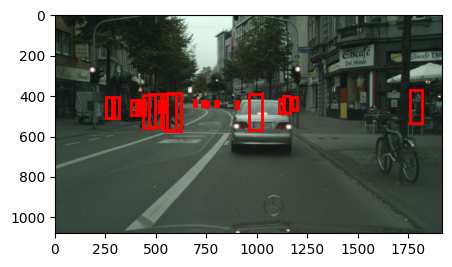

In [9]:
# plotting the image with bboxes. Feel free to change the index
img, target = test_dataset[7]
plot_img_bbox(img, target)

In [10]:

def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [11]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
            A.HorizontalFlip(0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
            A.Rotate(limit=15, p=0.5),
            ToTensorV2(p=1.0)
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [12]:
# use our dataset and defined transformations
train_dataset = ImagesDataset(train_dir, 1920, 1080, transforms= get_transform(train=True))
test_dataset = ImagesDataset(test_dir, 1920, 1080, transforms= get_transform(train=False))

# define training and validation data loaders
data_loader_train= torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=4, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [13]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 2

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 166MB/s]


In [14]:
# training for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/74]  eta: 0:05:04  lr: 0.000073  loss: 0.9689 (0.9689)  loss_classifier: 0.6910 (0.6910)  loss_box_reg: 0.2470 (0.2470)  loss_objectness: 0.0142 (0.0142)  loss_rpn_box_reg: 0.0167 (0.0167)  time: 4.1166  data: 1.4555  max mem: 4799
Epoch: [0]  [10/74]  eta: 0:01:01  lr: 0.000758  loss: 0.7122 (0.7553)  loss_classifier: 0.4492 (0.4562)  loss_box_reg: 0.2731 (0.2704)  loss_objectness: 0.0152 (0.0154)  loss_rpn_box_reg: 0.0110 (0.0134)  time: 0.9576  data: 0.1578  max mem: 4957
Epoch: [0]  [20/74]  eta: 0:00:43  lr: 0.001442  loss: 0.6434 (0.6511)  loss_classifier: 0.2711 (0.3454)  loss_box_reg: 0.2737 (0.2768)  loss_objectness: 0.0152 (0.0171)  loss_rpn_box_reg: 0.0103 (0.0118)  time: 0.6427  data: 0.0291  max mem: 4958
Epoch: [0]  [30/74]  eta: 0:00:33  lr: 0.002126  loss: 0.4094 (0.5594)  loss_classifier: 0.1446 (0.2677)  loss_box_reg: 0.2365 (0.2657)  loss_objectness: 0.0132 (0.0161)  loss_rpn_box_reg: 0.0062 (0.0099)  time: 0.6426  data: 0.0302  max mem: 4958
Epoch: [